In [5]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## read df and filter

In [6]:
subj = 'FINAL'
df = pd.read_csv(glob.glob(f'../results/formatted/*{subj}*csv')[0])[:-1]

# 1.
for col in ['positions']:
    if type(df[col][0]) == str:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x)) # convert str to list

# 3. # get dist between targer & last position
df['MAE_unnormed'] = abs(df['target_pos'] - df['positions'].apply(lambda x: x[-1]))
df['MAE_normed'] = np.where(
    ((df['condition'] == 'pen_comp') & (df['valence'] == 'pen')) | ((df['condition'] == 'rew_comp') & (df['valence'] == 'rew')),
    df['MAE_unnormed']*2, 
    df['MAE_unnormed']
)

# 4.
df['dist'] = df['positions'].apply(lambda x: abs(x[-1] - x[0]))
df['avg_speed'] = df['dist'] / df['trials.submit_resp.rt']

# 5.
df['choice'] = df['outcome'].apply(lambda x: 1 if abs(x) == 2 else 0 if abs(x) == 1 else 0)
# df = df[df['choice'] != 0]

# 6.
# filtering out easy trials
df_hard = df[df['target_pos'] - df['div_pos'] <= .05].copy()
print(f'% trials with |target-divider| <= .1: {len(df_hard)/len(df): .02f}')

% trials with |target-divider| <= .1:  0.57


## duration checks

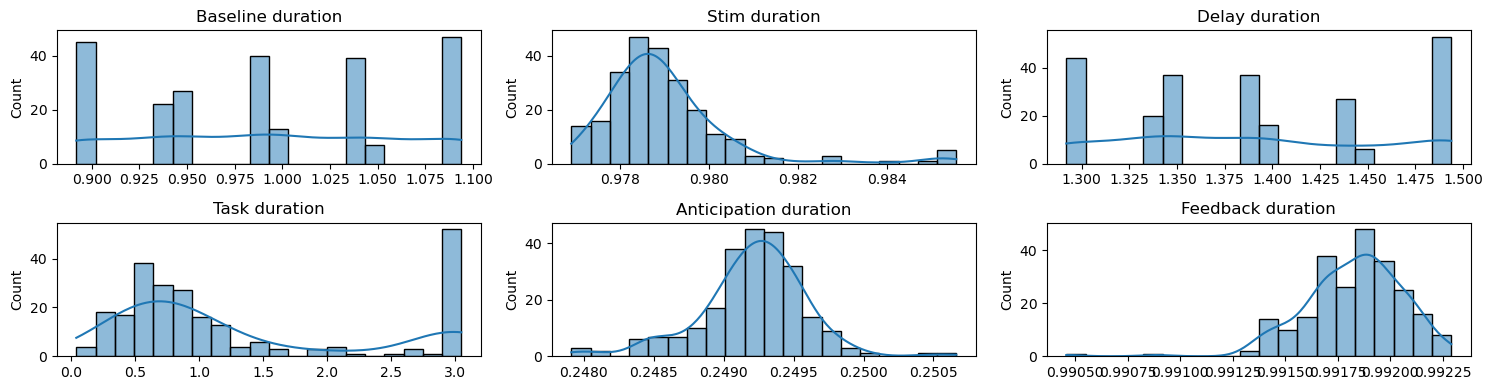

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239],
      dtype='int64', length=240)


In [12]:
df['base_dur'] = df['baseline.stopped'] - df['baseline.started']
df['stim_dur'] = df['stim.stopped'] - df['target_stim.started']
df['delay_dur'] = df['delay.stopped'] - df['delay.started']
df['task_dur'] = df['task.stopped'] - df['task.started']
df['anticipation_dur'] = df['anticipation.stopped'] - df['anticipation.started']
df['feedback_dur'] = df['feedback.stopped'] - df['no_resp_text.started']

df_plot = df[1:].copy()
df_plot = df.copy()

fig, axs = plt.subplots(2, 3, figsize=(15, 4))
axs = axs.flatten()

ax = axs[0]
sns.histplot(df_plot['base_dur'], bins=20, kde=True, ax=ax)
ax.set_title('Baseline duration')
ax.set_xlabel('')
ax.set_ylabel('Count')

ax = axs[1]
sns.histplot(df_plot['stim_dur'], bins=20, kde=True, ax=ax)
ax.set_title('Stim duration')
ax.set_xlabel('')
ax.set_ylabel('Count')

ax = axs[2]
sns.histplot(df_plot['delay_dur'], bins=20, kde=True, ax=ax)
ax.set_title('Delay duration')
ax.set_xlabel('')
ax.set_ylabel('Count')

ax = axs[3]
sns.histplot(df_plot['task_dur'], bins=20, kde=True, ax=ax)
ax.set_title('Task duration')
ax.set_xlabel('')
ax.set_ylabel('Count')

ax = axs[4]
sns.histplot(df_plot['anticipation_dur'], bins=20, kde=True, ax=ax)
ax.set_title('Anticipation duration')
ax.set_xlabel('')
ax.set_ylabel('Count')

ax = axs[5]
sns.histplot(df_plot['feedback_dur'], bins=20, kde=True, ax=ax)
ax.set_title('Feedback duration')
ax.set_xlabel('')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

# print which rows have feedback less than .99
print(df.loc[df['feedback_dur'] < 0.998].index)


## 1. analyses by valence & compression

condition
baseline    80
pen_comp    80
rew_comp    80
Name: count, dtype: int64
correct
0.0    163
1.0     77
Name: count, dtype: int64


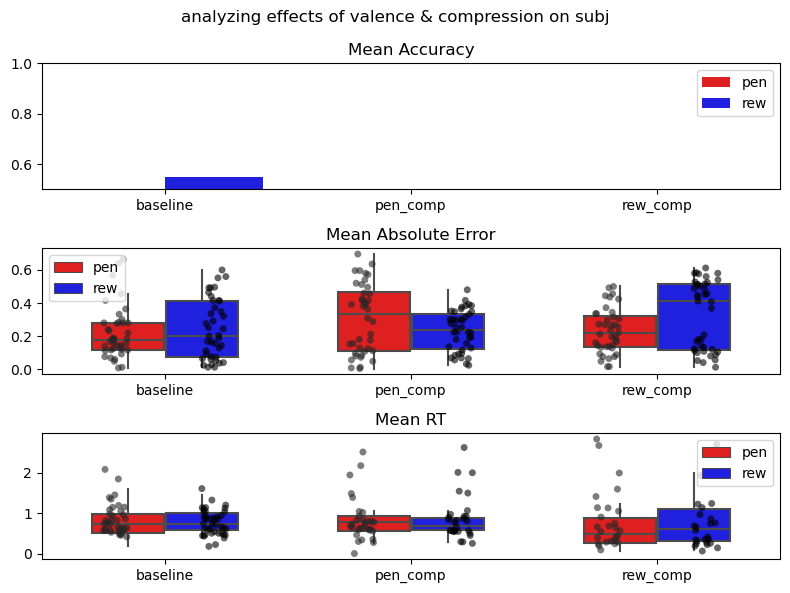

In [8]:
# df_plot = df_hard.copy()
df_plot = df.copy()

df_plot['correct'] = df_plot['correct'].apply(lambda x: 0 if x == -1 else x)
print(df_plot['condition'].value_counts())
print(df_plot['correct'].value_counts())

fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes = axes.flatten()
fig.suptitle('analyzing effects of valence & compression on subj')
palette, hue_order = {'rew': 'blue', 'pen': 'red'}, ['pen', 'rew']

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='condition', y='correct', hue='valence', hue_order=hue_order, palette = palette, ax=ax, errorbar=None)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')
ax.legend()

# 2.
ax = axes[1]
sns.boxplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order,
            palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
sns.stripplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order, 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean Absolute Error')
ax.legend()

# 3.
ax = axes[2]
sns.boxplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', hue_order = hue_order,
            palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
sns.stripplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()


plt.tight_layout()
plt.show()

## analyses by valence space

percept_space
very_flat     60
curvy         60
very_curvy    60
flat          60
Name: count, dtype: int64


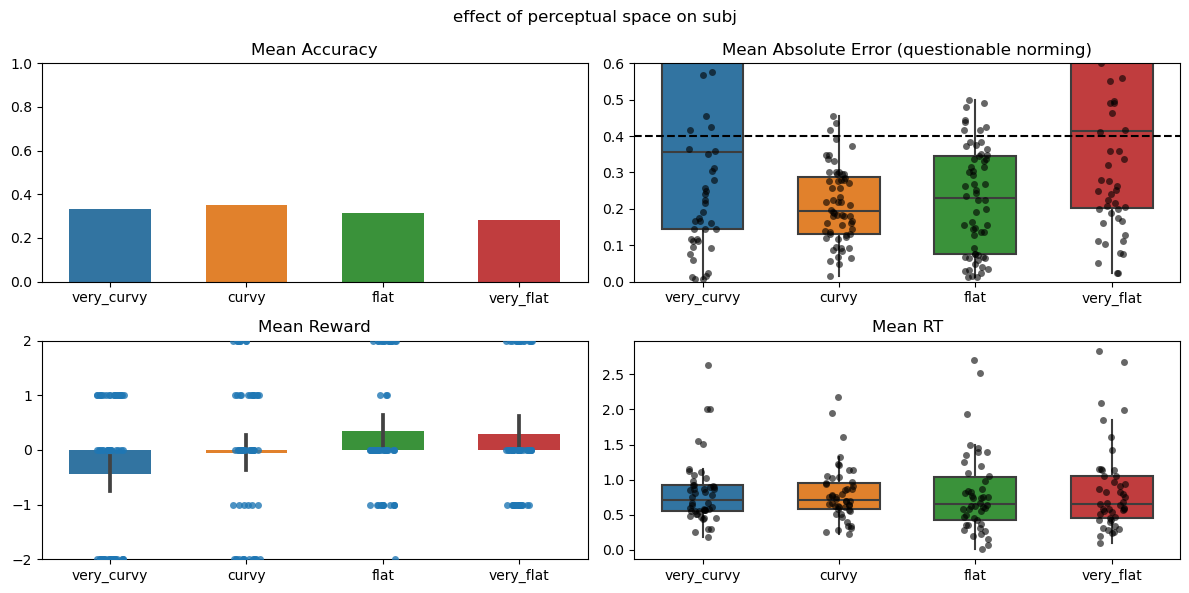

In [9]:
df_plot = df.copy()

conditions = [
    (-0.4 < df_plot['stim_pos']) & (df_plot['stim_pos'] < -0.2),
    (-0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0),
    (0 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.2),
    (0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.4)
]
percept_labels = ['very_curvy', 'curvy', 'flat', 'very_flat']
df_plot['percept_space'] = np.select(conditions, percept_labels)

# arnav's percept space will be flipped
print(df_plot['percept_space'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('effect of perceptual space on subj')

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='percept_space', y='correct', width=0.6, ax=ax, errorbar=None, order=percept_labels)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_title('Mean Accuracy')

# 2. MAE
ax = axes[1]
sns.boxplot(data=df_plot, x='percept_space', y='MAE_normed', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
sns.stripplot(data=df_plot, x='percept_space', y='MAE_normed', color='black', dodge=True, alpha=0.6, jitter=True, legend=False, order=percept_labels, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, .6)
ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
ax.set_title('Mean Absolute Error (questionable norming)')

# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='percept_space', y='outcome', width=0.6, hue_order=hue_order, order=percept_labels, ax=ax)
sns.stripplot(data=df_plot, x='percept_space', y='outcome', dodge=True, alpha=0.8, jitter=True, order=percept_labels, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')

# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
sns.stripplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', color='black', dodge=True, alpha=0.6, jitter=True, order=percept_labels, legend=True, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')

plt.tight_layout()
plt.show()

